In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, RandomSampler
import matplotlib.pyplot as plt
import time
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

from mnist_classifier.model import Mnist_classifer





In [2]:
batch = 256
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)


mnist_indice = torch.randperm(len(mnist))
mnist_train_sampler = RandomSampler(mnist_indice[:int(len(mnist) * 0.9)])
mnist_valid_sampler = RandomSampler(mnist_indice[int(len(mnist) * 0.9):])


mnist_train_dataloader = DataLoader(mnist, sampler=mnist_train_sampler, batch_size=batch)
mnist_val_dataloader = DataLoader(mnist, sampler=mnist_valid_sampler, batch_size=batch)

# for x, y in mnist_train_dataloader:
#     print(x[1])
#     print(y[1])
#     break
# for x, y in mnist_val_dataloader:
#     print(x[1])
#     print(y[1])
#     break

In [3]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

    

        self.output = nn.Sequential(nn.Linear(200, 256),#雜訊是長度512的tensor
                                    nn.BatchNorm1d(256),
                                    nn.LeakyReLU(),
                                    nn.Linear(256, 512),
                                    nn.BatchNorm1d(512),
                                    nn.LeakyReLU(),
                                    nn.Linear(512, 1024),
                                    nn.BatchNorm1d(1024),
                                    nn.LeakyReLU(),
                                    nn.Linear(1024, 784),
                                    nn.Tanh())#輸出值域要藉於-1~1
        
        self.output.apply(self.init_net_work)
    def forward(self, batch_size : int, use_gpu = False, generating = False):
        x = torch.rand(batch_size * 200)#隨機正態分布
        x = x.view(-1, 200)
        if (use_gpu): x = x.to(device="cuda", dtype=torch.float32)
        if (generating): print(x)
        return self.output(x)
    def generate_image(self, num : int):
        image = self.forward(batch_size=num, generating=True)
        image = image.view(-1, 28, 28).detach().numpy()
        image = (image + 1) * 255 / 2
        return image
    
    def init_net_work(self, tensor : torch.tensor): 
        if (type(tensor) == nn.Linear):
            nn.init.kaiming_uniform_(tensor.weight, nonlinearity='leaky_relu')
            nn.init.zeros_(tensor.bias)

In [4]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.output = nn.Sequential(nn.Linear(784, 1024),
                                    nn.LeakyReLU(),
                                    nn.Dropout(0.4),
                                    nn.Linear(1024, 512),
                                    nn.LeakyReLU(),
                                    nn.Dropout(0.3),
                                    nn.Linear(512, 256),
                                    nn.BatchNorm1d(256),
                                    nn.LeakyReLU(),
                                    nn.Linear(256, 1),
                                    nn.Sigmoid()
                                    )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.output(x)

tensor([[0.6924, 0.7989, 0.2358,  ..., 0.2153, 0.9671, 0.6329],
        [0.3878, 0.1764, 0.7851,  ..., 0.0048, 0.4126, 0.7965],
        [0.2062, 0.4870, 0.7781,  ..., 0.3849, 0.3909, 0.6409],
        ...,
        [0.1464, 0.3662, 0.5441,  ..., 0.7644, 0.5864, 0.6931],
        [0.9249, 0.0842, 0.1201,  ..., 0.3004, 0.9649, 0.7031],
        [0.1033, 0.1357, 0.0909,  ..., 0.4253, 0.5240, 0.9559]])


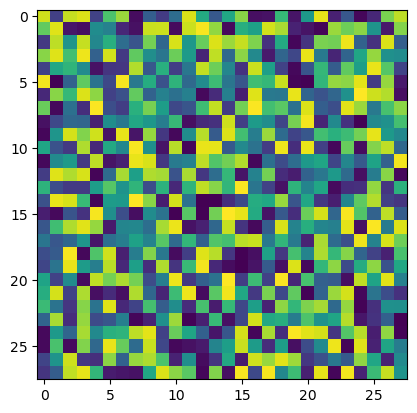

<All keys matched successfully>

In [5]:
#呼叫模型
generator = Generator()
classifier = Classifier()
image = generator.generate_image(10)
plt.imshow(image[0])
plt.show()

#使用手寫辨識模型
mnist_classifer = Mnist_classifer()
mnist_classifer_checkpoint = torch.load("mnist_classifier/checkpoint.pth")
mnist_classifer.load_state_dict(mnist_classifer_checkpoint)



In [6]:
#test classifier

def validate(classifier, loss_function, dataloader, use_gpu : bool):
    val_loss = 0
    acc = 0
    count = 0
    classifier.eval()
    with torch.no_grad():
        for x, y in dataloader:
            count += 1
            label = torch.ones(len(x))
            if (use_gpu):
                x = x.to(device="cuda", dtype=torch.float32)
                label = label.to(device="cuda", dtype=torch.float32)

            predict = classifier(x)
            label = label.view(predict.shape)
            loss = loss_function(predict, label)
            val_loss += loss
            acc += ((predict >= 0.5)).sum() / len(x)

    return val_loss / count, acc / count


In [7]:
use_gpu = torch.cuda.is_available()

epoch = 1000
lr = 0.0002
beta = (0.5, 0.999)

optim_G = optim.Adam(generator.parameters(), lr=lr, betas=beta, weight_decay=0.5)
optim_C = optim.Adam(classifier.parameters(), lr=lr, betas=beta)
loss_function = nn.BCELoss()

fake_label = torch.ones(2*batch)#整個在騙的標籤會一直用到

if (use_gpu):
    print("GPU")
    loss_function = loss_function.to(device="cuda", dtype=torch.float32)
    #generator = generator.to(device="cuda", dtype=torch.float32)
    classifier = classifier.to(device="cuda", dtype=torch.float32)
    fake_label = fake_label.to(device="cuda", dtype=torch.float32)

GPU


epoch: 1:
classifier train loss: 0.01797157121287223, val loss: 0.002696158131584525, val acc: 1.0
save model
generator loss: 0.8665772455169799
tensor([[0.7632, 0.8225, 0.7156,  ..., 0.3067, 0.9490, 0.8808],
        [0.1455, 0.5812, 0.2231,  ..., 0.1973, 0.4959, 0.9146],
        [0.4263, 0.0577, 0.5282,  ..., 0.1463, 0.2903, 0.8266],
        ...,
        [0.8616, 0.8602, 0.2308,  ..., 0.5525, 0.5785, 0.8248],
        [0.0133, 0.4442, 0.9729,  ..., 0.1236, 0.1499, 0.7331],
        [0.1134, 0.1233, 0.1637,  ..., 0.8370, 0.7848, 0.1357]])


C:\Users\weiso131\AppData\Local\Temp\ipykernel_16452\2037420344.py:116: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  topk, top_class = mnist_classifer(torch.tensor(fake_images)).topk(1, dim=1)


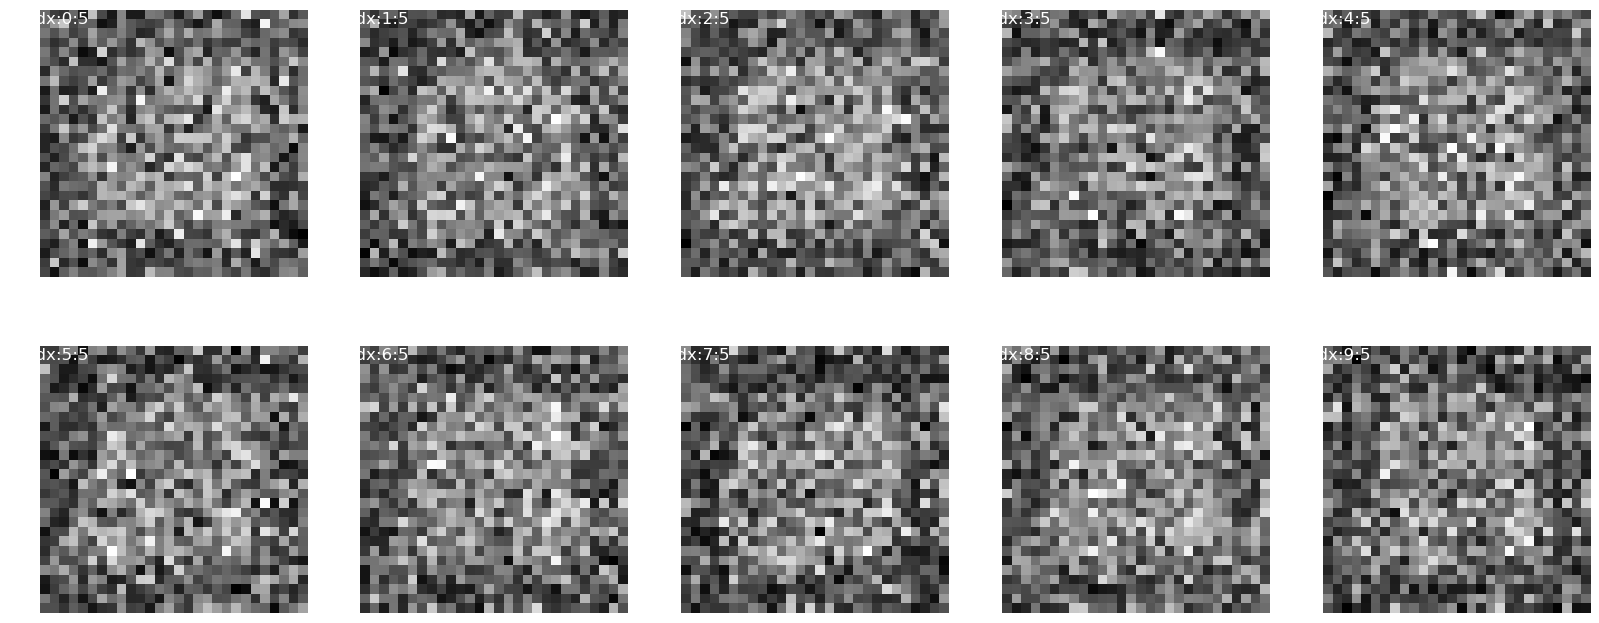

epoch: 2:
classifier train loss: 0.0022222459197361417, val loss: 0.0009854510426521301, val acc: 1.0
save model
generator loss: 0.14001010836280406
epoch: 3:
classifier train loss: 0.0012400375121827932, val loss: 0.0005086100427433848, val acc: 1.0
save model
generator loss: 0.15264619020547004
epoch: 4:
classifier train loss: 0.0008586103552357948, val loss: 0.0002627767389640212, val acc: 1.0
save model
generator loss: 0.135596834991048
epoch: 5:
classifier train loss: 0.0007984112020572053, val loss: 0.00023712367692496628, val acc: 1.0
save model
generator loss: 0.1993719321853937
epoch: 6:
classifier train loss: 0.0010780139409496071, val loss: 0.00012183842773083597, val acc: 1.0
save model
generator loss: 0.11503883529017293
tensor([[0.6791, 0.6616, 0.4924,  ..., 0.1017, 0.5067, 0.2521],
        [0.7800, 0.7242, 0.1348,  ..., 0.0463, 0.5140, 0.9548],
        [0.1400, 0.1620, 0.3727,  ..., 0.8240, 0.1610, 0.2043],
        ...,
        [0.2503, 0.0998, 0.5197,  ..., 0.8690, 0.70

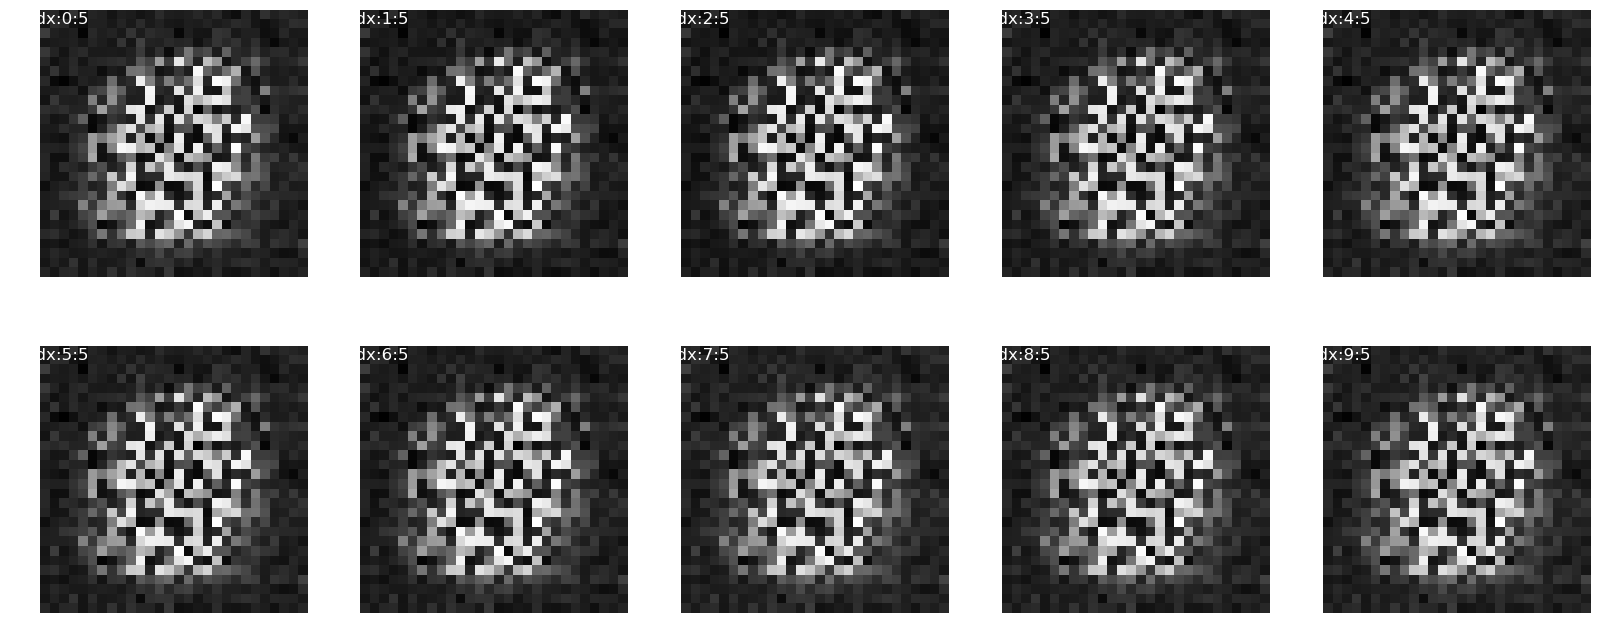

epoch: 7:
classifier train loss: 0.0046518503767537306, val loss: 0.00021919896244071424, val acc: 1.0
generator loss: 0.24890451134043806
epoch: 8:
classifier train loss: 0.0036114702265006193, val loss: 0.0001454931334592402, val acc: 1.0
generator loss: 0.20046307012597298
epoch: 9:
classifier train loss: 0.0036432424374420115, val loss: 0.0002124907186953351, val acc: 1.0
generator loss: 0.2800679270455495
epoch: 10:
classifier train loss: 0.004732120517477829, val loss: 0.00013667029270436615, val acc: 1.0
generator loss: 0.23438892617346124
epoch: 11:
generator loss: 0.16882093096587886
tensor([[0.4155, 0.5986, 0.3207,  ..., 0.9668, 0.1474, 0.8387],
        [0.6360, 0.4932, 0.7832,  ..., 0.9759, 0.7246, 0.4169],
        [0.0696, 0.5415, 0.0615,  ..., 0.6410, 0.8020, 0.3566],
        ...,
        [0.3370, 0.6888, 0.2962,  ..., 0.8925, 0.4375, 0.6563],
        [0.5990, 0.6333, 0.3785,  ..., 0.4663, 0.0523, 0.9669],
        [0.4498, 0.9749, 0.8466,  ..., 0.6035, 0.8874, 0.0425]])


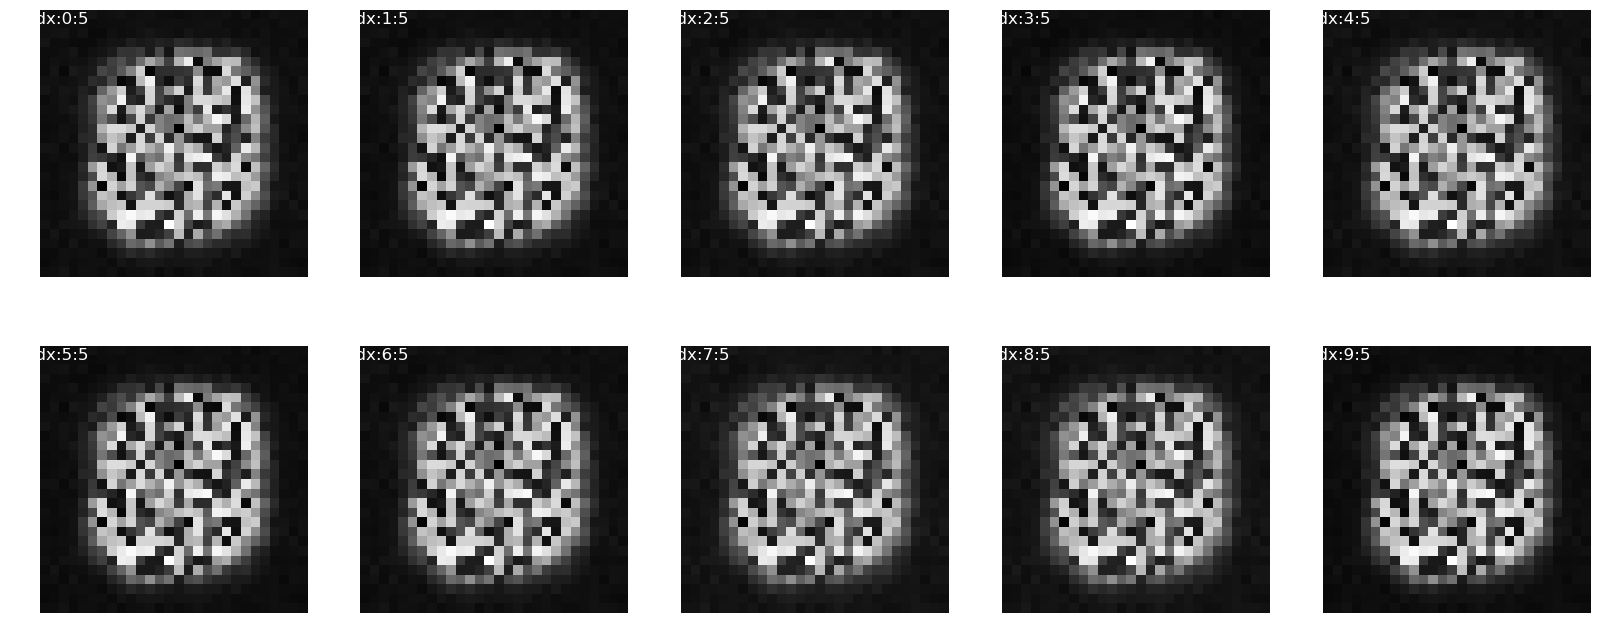

epoch: 12:
generator loss: 0.17132234816300743
epoch: 13:
generator loss: 0.19095311802910997
epoch: 14:
generator loss: 0.20551495972148914
epoch: 15:
generator loss: 0.22037777043086418
epoch: 16:
generator loss: 0.2402918984915348
tensor([[0.1699, 0.8773, 0.1525,  ..., 0.3848, 0.5944, 0.9242],
        [0.8734, 0.2019, 0.7676,  ..., 0.7764, 0.3655, 0.7824],
        [0.8047, 0.7773, 0.5972,  ..., 0.7532, 0.1678, 0.4272],
        ...,
        [0.4918, 0.9410, 0.8743,  ..., 0.3090, 0.1102, 0.5790],
        [0.7984, 0.0604, 0.8848,  ..., 0.2663, 0.4364, 0.0507],
        [0.8676, 0.6577, 0.4185,  ..., 0.7616, 0.5002, 0.5056]])


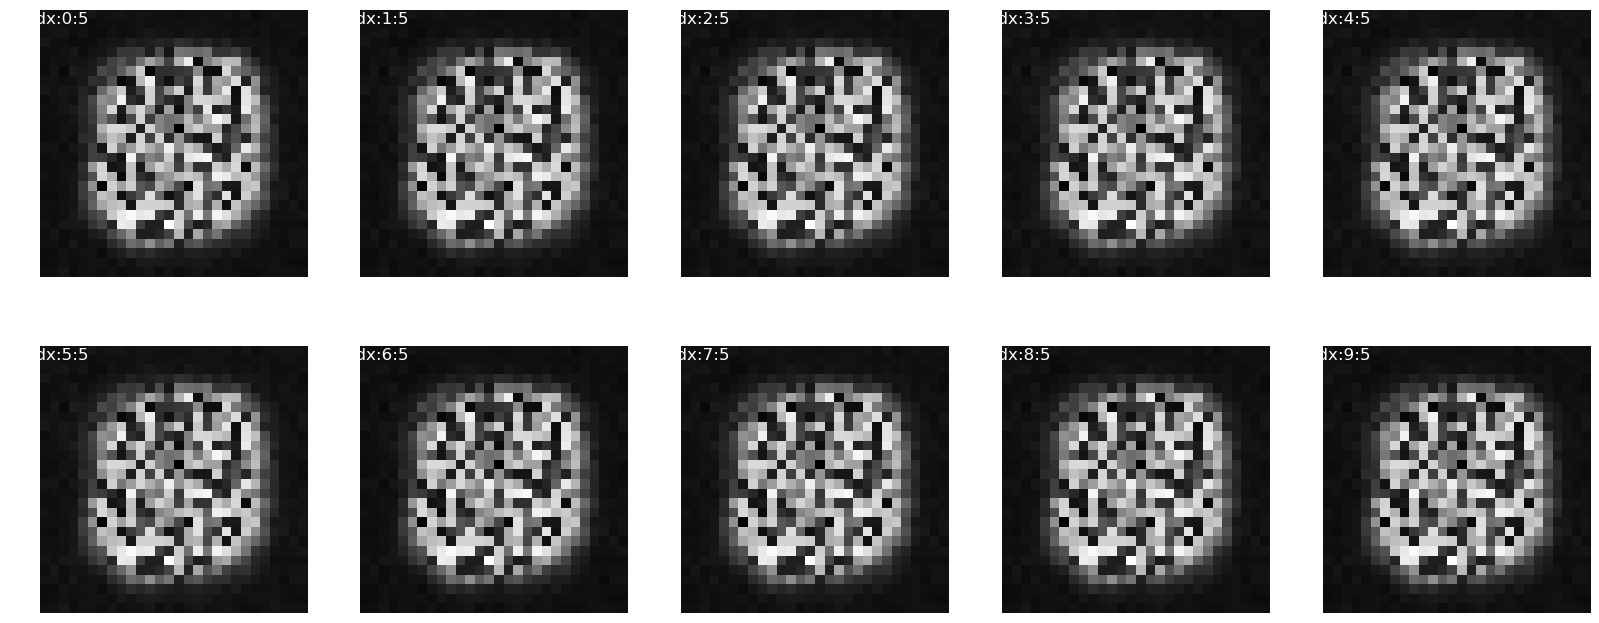

epoch: 17:
generator loss: 0.2627510836149784
epoch: 18:
generator loss: 0.27697052556149504
epoch: 19:


KeyboardInterrupt: 

In [8]:
classifier_loss = [1]
generator_loss = [0]
count = 235
min_val_loss = 1e9
max_val_acc = 0



mnist_classifer.eval()
for i in range(epoch):
    print(f"epoch: {i + 1}:")
    
    classifier_loss_epoch = 0
    generator_loss_epoch = 0
    
    classifier.train()

    if (i < 10 or generator_loss[len(generator_loss) - 1] < 0.05):
        for x, y in mnist_train_dataloader:
            optim_C.zero_grad()

            #reshape mnist data
            x = x.view(-1, 784)     
            #生成假資料
            with torch.no_grad(): fake_mnist = generator(batch_size=len(x))#不要被訓練到

            #合併資料
            train_data = torch.cat((x, fake_mnist))                        
            train_label = torch.cat((torch.ones(len(x)), torch.zeros(len(x))))

            #生成隨機排序
            random_indice = torch.randperm(2 * len(x))

            #隨機分布
            train_data = train_data[random_indice] 
            train_label = train_label[random_indice]

            
            if (use_gpu): 
                train_data = train_data.to(device="cuda", dtype=torch.float32)
                train_label = train_label.to(device="cuda", dtype=torch.float32)

            predict = classifier(train_data)

            train_label = train_label.view(predict.shape)

            #反向傳播
            c_loss = loss_function(predict, train_label)
            c_loss.backward()

            nn.utils.clip_grad_value_(classifier.parameters(), 3)

            optim_C.step()

            
            classifier_loss_epoch += c_loss.item()

        

        val_loss, val_acc = validate(classifier, loss_function, mnist_val_dataloader, use_gpu)
        print(f"classifier train loss: {classifier_loss_epoch / count}, val loss: {val_loss}, val acc: {val_acc}")


        #把最好的辨識器保存
        if (val_acc > max_val_acc or (val_acc == max_val_acc and val_loss < min_val_loss)):
            max_val_acc = val_acc
            min_val_loss = val_loss
            checkpoint = classifier.state_dict()
            torch.save(checkpoint, "classifier_checkpoint.pth")
            print("save model")
        #辨識器壞了，拿最好的重新開始
        elif (val_acc < max_val_acc):
            checkpoints = torch.load("classifier_checkpoint.pth")
            classifier.load_state_dict(checkpoint)
            print("redo model")


        classifier_loss.append(classifier_loss_epoch / count)


    #訓練生成器
    classifier.eval()
    
    if (use_gpu): generator = generator.to(device="cuda", dtype=torch.float32)
        
    for j in range(count):
        optim_G.zero_grad()

        fake_mnist = generator(batch_size=2*batch, use_gpu=use_gpu)
        
        predict = classifier(fake_mnist)

        fake_label = fake_label.view(predict.shape)
        #反向傳播
        g_loss = loss_function(predict, fake_label)
        g_loss.backward()
        optim_G.step()

        

        generator_loss_epoch += g_loss.item()

    if (use_gpu):generator = generator.to(device="cpu", dtype=torch.float32)
        
    
    
    print(f"generator loss: {generator_loss_epoch / count}")
    print("===========================================")
    generator_loss.append(generator_loss_epoch / count)

    torch.cuda.empty_cache()

    if (i % 5 == 0):
        fake_images = generator.generate_image(num=10).squeeze()
        fake_images = torch.tensor(fake_images)
        topk, top_class = mnist_classifer(torch.tensor(fake_images)).topk(1, dim=1)

        fig, axs = plt.subplots(2, 5, figsize=(20, 8))  # 創建一個2x5的子圖網路
        
        for i, ax in enumerate(axs.flat):
            
            ax.imshow(fake_images[i], cmap='gray')  # 顯示圖片
            ax.text(0.5, 0.5, "inedx:" + str(i) + ":" + str(top_class[i].item()), fontsize=12, ha='center', va='center', color='white')
            ax.axis('off')  # 關閉坐標軸
           

        plt.show()
